In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np

df = pd.read_csv('KRfin01.csv')
df2 = pd.read_csv('KRfin02.csv')
df = df.append(df2, ignore_index=True)
print(df.shape[0])

19941


In [2]:
train_X,val_X,test_X=np.array(df.iloc[:15952,1:-1]),np.array(df.iloc[15952::2,1:-1]),np.array(df.iloc[15953::2,1:-1])
train_Y,val_Y,test_Y=np.array(df.iloc[:15952,-1]),np.array(df.iloc[15952::2,-1]),np.array(df.iloc[15953::2,-1])

In [3]:
from collections import Counter
print(f"In train set(15952): {Counter(train_Y)[0]} win and {Counter(train_Y)[1]} lose")
print(f"In val set(1995): {Counter(val_Y)[0]} win and {Counter(val_Y)[1]} lose")
print(f"In test set(1994): {Counter(test_Y)[0]} win and {Counter(test_Y)[1]} lose")

In train set(15952): 7928 win and 8024 lose
In val set(1995): 960 win and 1035 lose
In test set(1994): 975 win and 1019 lose


In [4]:
train_data=TensorDataset(torch.from_numpy(train_X),torch.from_numpy(train_Y))
val_data=TensorDataset(torch.from_numpy(val_X),torch.from_numpy(val_Y))
test_data=TensorDataset(torch.from_numpy(test_X),torch.from_numpy(test_Y))

In [5]:
#find out the number positive and negative examples in the training set
num_classes=[Counter(train_Y)[0],Counter(train_Y)[1]]
#find the respective weights (mind that weights need to be a torch tensor)
weights=1./torch.tensor(num_classes,dtype=float)
#create a torch tensor associating the train_Y and the weights. Sample Weights is a torch tensor
sample_weights=weights[train_Y]
sampler=torch.utils.data.WeightedRandomSampler(weights=sample_weights,num_samples=len(sample_weights),replacement=True)

In [6]:
batch_size=100
train_loader=DataLoader(train_data,sampler=sampler,batch_size=batch_size)
val_loader=DataLoader(val_data,shuffle=True,batch_size=batch_size)
test_loader=DataLoader(test_data,shuffle=False,batch_size=batch_size)

In [7]:
train_iter=iter(val_loader)
inputs,outputs=train_iter.next()
print(inputs)

tensor([[0.4426, 0.4155, 0.4834,  ..., 0.5186, 0.4681, 0.5037],
        [0.5098, 0.4632, 0.5251,  ..., 0.4392, 0.4158, 0.4761],
        [0.4891, 0.5416, 0.5335,  ..., 0.4737, 0.4982, 0.4512],
        ...,
        [0.5235, 0.4011, 0.4558,  ..., 0.4432, 0.5630, 0.5413],
        [0.4623, 0.5613, 0.4032,  ..., 0.4693, 0.5359, 0.4959],
        [0.4462, 0.5312, 0.3702,  ..., 0.4293, 0.5428, 0.5563]],
       dtype=torch.float64)


In [8]:
print(inputs.size())

torch.Size([100, 23])


In [9]:
#loader wrapping
loaders={'train':train_loader, 'valid':val_loader}

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1=nn.Linear(23,32)
        self.norm1=nn.BatchNorm1d(32)
        self.fc2=nn.Linear(32,16,bias=False)
        self.norm2=nn.BatchNorm1d(16)
        self.fc3=nn.Linear(16,8,bias=False)
        self.norm3=nn.BatchNorm1d(8)
        self.fc4=nn.Linear(8,5,bias=False)
        self.norm4=nn.BatchNorm1d(5)
        self.fc5=nn.Linear(5,1)
         
    def forward(self,x):
        x=F.relu(self.norm1(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x=F.relu(self.norm2(self.fc2(x)))
        x = F.dropout(x, training=self.training)
        x=F.relu(self.norm3(self.fc3(x)))
        #x = F.dropout(x, training=self.training)
        x=F.relu(self.norm4(self.fc4(x)))
        x = F.dropout(x, training=self.training)
        x=self.fc5(x)        
        return x

In [11]:
model = Net()
criterion=nn.BCEWithLogitsLoss()
Net()

Net(
  (fc1): Linear(in_features=23, out_features=32, bias=True)
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=16, bias=False)
  (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=8, bias=False)
  (norm3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=8, out_features=5, bias=False)
  (norm4): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.75,patience=50,min_lr=1e-5) 

In [13]:
def train(n_epochs,loaders,model,optimizer,criterion,scheduler):
    valid_loss_min=np.Inf
    list_train_loss=[]
    list_valid_loss=[]
    for epoch in range(1,n_epochs+1):
        train_loss=0.0
        valid_loss=0.0
        model.train()
        for batch_idx,(data,target) in enumerate(loaders["train"]):
            optimizer.zero_grad()
            output=model(data.float())
            loss=criterion(output.squeeze(),target.float())
            loss.backward()
            optimizer.step()
            train_loss=train_loss+1/(batch_idx+1)*(loss.item()-train_loss)
        list_train_loss.append(train_loss)
        print("At {} epoch, Training Loss: {} ".format(epoch,train_loss))
        model.eval()
        for batch_idx,(data,target) in enumerate(loaders["valid"]):
            output=model(data.float())
            loss=criterion(output.squeeze(),target.float())
            valid_loss=valid_loss+1/(batch_idx+1)*(loss.item()-valid_loss)
        scheduler.step(valid_loss)
        list_valid_loss.append(valid_loss)
        print("At {} epoch, Validation Loss: {} ".format(epoch,valid_loss))
        #Save the model
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(),'ccFraud.pt')
            print("Minimum validation loss detected, saving model......................................................................................")
            valid_loss_min=valid_loss
    
    return model, list_train_loss, list_valid_loss

In [14]:
n_epoch=500
model,train_loss,valid_loss=train(n_epoch,loaders,model,optimizer,criterion,scheduler)

At 1 epoch, Training Loss: 0.7133112132549282 
At 1 epoch, Validation Loss: 0.695347875356674 
Minimum validation loss detected, saving model......................................................................................
At 2 epoch, Training Loss: 0.6999443348497147 
At 2 epoch, Validation Loss: 0.6949033975601195 
Minimum validation loss detected, saving model......................................................................................
At 3 epoch, Training Loss: 0.6962712775915862 
At 3 epoch, Validation Loss: 0.694761747121811 
Minimum validation loss detected, saving model......................................................................................
At 4 epoch, Training Loss: 0.69490125477314 
At 4 epoch, Validation Loss: 0.694350266456604 
Minimum validation loss detected, saving model......................................................................................
At 5 epoch, Training Loss: 0.6942965764552355 
At 5 epoch, Validation Loss: 0.69411695897

At 58 epoch, Training Loss: 0.6909635182470083 
At 58 epoch, Validation Loss: 0.6904861241579056 
At 59 epoch, Training Loss: 0.6886950567364695 
At 59 epoch, Validation Loss: 0.6910192131996155 
At 60 epoch, Training Loss: 0.68890317119658 
At 60 epoch, Validation Loss: 0.6910494476556777 
At 61 epoch, Training Loss: 0.6900945920497179 
At 61 epoch, Validation Loss: 0.6911063939332962 
At 62 epoch, Training Loss: 0.6900424983352427 
At 62 epoch, Validation Loss: 0.6913325399160384 
At 63 epoch, Training Loss: 0.6898618180304763 
At 63 epoch, Validation Loss: 0.6919868677854538 
At 64 epoch, Training Loss: 0.6893341124057768 
At 64 epoch, Validation Loss: 0.6915670275688172 
At 65 epoch, Training Loss: 0.6903624597936864 
At 65 epoch, Validation Loss: 0.6918910443782805 
At 66 epoch, Training Loss: 0.6876327294856309 
At 66 epoch, Validation Loss: 0.693524518609047 
At 67 epoch, Training Loss: 0.6902521904557946 
At 67 epoch, Validation Loss: 0.6915023148059845 
At 68 epoch, Training L

At 137 epoch, Training Loss: 0.6867939386516813 
At 137 epoch, Validation Loss: 0.6914768487215043 
At 138 epoch, Training Loss: 0.6860365461558111 
At 138 epoch, Validation Loss: 0.6919278174638748 
At 139 epoch, Training Loss: 0.6872687600553036 
At 139 epoch, Validation Loss: 0.6912701606750488 
At 140 epoch, Training Loss: 0.686841654777527 
At 140 epoch, Validation Loss: 0.6921200096607207 
At 141 epoch, Training Loss: 0.6863680694252255 
At 141 epoch, Validation Loss: 0.6915655732154846 
At 142 epoch, Training Loss: 0.688344115763903 
At 142 epoch, Validation Loss: 0.6915358543395996 
At 143 epoch, Training Loss: 0.6886893492192028 
At 143 epoch, Validation Loss: 0.6912687063217163 
At 144 epoch, Training Loss: 0.6877977497875694 
At 144 epoch, Validation Loss: 0.6934344500303269 
At 145 epoch, Training Loss: 0.6866193655878305 
At 145 epoch, Validation Loss: 0.6913769155740737 
At 146 epoch, Training Loss: 0.6865017250180248 
At 146 epoch, Validation Loss: 0.6916255265474319 
At

At 214 epoch, Training Loss: 0.685430125892162 
At 214 epoch, Validation Loss: 0.6904507577419281 
At 215 epoch, Training Loss: 0.6865765929222108 
At 215 epoch, Validation Loss: 0.6903118550777435 
At 216 epoch, Training Loss: 0.6851585436612366 
At 216 epoch, Validation Loss: 0.6893782317638397 
Minimum validation loss detected, saving model......................................................................................
At 217 epoch, Training Loss: 0.6854408416897058 
At 217 epoch, Validation Loss: 0.6917240977287292 
At 218 epoch, Training Loss: 0.6867874484509233 
At 218 epoch, Validation Loss: 0.689919701218605 
At 219 epoch, Training Loss: 0.6871902152895925 
At 219 epoch, Validation Loss: 0.689953711628914 
At 220 epoch, Training Loss: 0.6853094659745694 
At 220 epoch, Validation Loss: 0.6902247697114945 
At 221 epoch, Training Loss: 0.6854205418378115 
At 221 epoch, Validation Loss: 0.6898583203554154 
At 222 epoch, Training Loss: 0.6870256748050453 
At 222 epoch, Validat

At 294 epoch, Training Loss: 0.6852658186107873 
At 294 epoch, Validation Loss: 0.6900533616542815 
At 295 epoch, Training Loss: 0.685781967639923 
At 295 epoch, Validation Loss: 0.6906825512647629 
At 296 epoch, Training Loss: 0.6845777604728939 
At 296 epoch, Validation Loss: 0.6887775987386704 
Minimum validation loss detected, saving model......................................................................................
At 297 epoch, Training Loss: 0.6840450141578912 
At 297 epoch, Validation Loss: 0.6900669664144516 
At 298 epoch, Training Loss: 0.6848349954932929 
At 298 epoch, Validation Loss: 0.6904726475477219 
At 299 epoch, Training Loss: 0.6853152345865966 
At 299 epoch, Validation Loss: 0.6900989174842834 
At 300 epoch, Training Loss: 0.6855975378304717 
At 300 epoch, Validation Loss: 0.6889995634555816 
At 301 epoch, Training Loss: 0.6858128324151042 
At 301 epoch, Validation Loss: 0.6890704631805419 
At 302 epoch, Training Loss: 0.6864399261772631 
At 302 epoch, Valid

At 371 epoch, Training Loss: 0.6850590649992225 
At 371 epoch, Validation Loss: 0.6902014046907424 
At 372 epoch, Training Loss: 0.6841400660574442 
At 372 epoch, Validation Loss: 0.6912703186273577 
At 373 epoch, Training Loss: 0.684273881837726 
At 373 epoch, Validation Loss: 0.6927472710609436 
At 374 epoch, Training Loss: 0.6831819787621497 
At 374 epoch, Validation Loss: 0.6910486906766892 
At 375 epoch, Training Loss: 0.6835588783025742 
At 375 epoch, Validation Loss: 0.6899774610996247 
At 376 epoch, Training Loss: 0.6857758153229951 
At 376 epoch, Validation Loss: 0.6896387070417406 
At 377 epoch, Training Loss: 0.6841124165803194 
At 377 epoch, Validation Loss: 0.690736624598503 
At 378 epoch, Training Loss: 0.6834895741194488 
At 378 epoch, Validation Loss: 0.6900037974119188 
At 379 epoch, Training Loss: 0.6848978895694019 
At 379 epoch, Validation Loss: 0.6899360477924346 
At 380 epoch, Training Loss: 0.6840698312968015 
At 380 epoch, Validation Loss: 0.6895460665225982 
At

At 454 epoch, Training Loss: 0.6843411348760126 
At 454 epoch, Validation Loss: 0.6905455827713013 
At 455 epoch, Training Loss: 0.6819324638694523 
At 455 epoch, Validation Loss: 0.6908840417861939 
At 456 epoch, Training Loss: 0.6823311783373354 
At 456 epoch, Validation Loss: 0.6917145282030106 
At 457 epoch, Training Loss: 0.6840764116495844 
At 457 epoch, Validation Loss: 0.6908476263284684 
At 458 epoch, Training Loss: 0.6833333857357505 
At 458 epoch, Validation Loss: 0.6913846433162689 
At 459 epoch, Training Loss: 0.6831945732235907 
At 459 epoch, Validation Loss: 0.6900852948427201 
At 460 epoch, Training Loss: 0.6814248420298101 
At 460 epoch, Validation Loss: 0.6905754625797271 
At 461 epoch, Training Loss: 0.6843293413519858 
At 461 epoch, Validation Loss: 0.6914922654628753 
At 462 epoch, Training Loss: 0.6828332524746659 
At 462 epoch, Validation Loss: 0.6903480321168899 
At 463 epoch, Training Loss: 0.6829685252159832 
At 463 epoch, Validation Loss: 0.6909608840942384 


In [15]:
torch.load("ccFraud.pt")

OrderedDict([('fc1.weight',
              tensor([[-1.4138e-01, -6.0462e-02, -9.5733e-02,  7.3870e-02, -7.3791e-03,
                        2.1429e-02, -1.9180e-01, -1.7724e-01, -2.0179e-01, -1.4766e-01,
                       -3.3372e-02,  5.3046e-02,  9.7516e-02, -1.6881e-01, -2.3481e-01,
                       -1.8919e-01,  1.1018e-01, -7.7994e-03,  1.5687e-01, -2.5337e-01,
                        1.1768e-01, -8.4001e-02,  4.9440e-02],
                      [ 3.1972e-02,  1.6994e-01,  2.1667e-01,  1.5361e-01, -7.3494e-02,
                        2.3099e-01, -5.7540e-02,  1.1945e-01,  4.1076e-02,  1.5322e-01,
                       -5.9745e-02, -3.5819e-03,  1.9669e-02, -3.3753e-02,  1.0979e-01,
                       -5.8455e-02,  1.5564e-01,  5.6444e-02, -1.9274e-01,  1.2531e-01,
                       -5.8726e-02,  3.0291e-02,  2.2326e-01],
                      [-3.4549e-01,  5.4459e-03, -2.0313e-03, -7.6889e-02,  9.8695e-02,
                       -5.8035e-02,  1.2416e-01, -1.43

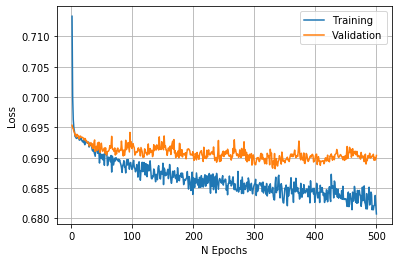

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

x_epochs=np.linspace(1,n_epoch,n_epoch).astype(dtype=int)
plt.plot(x_epochs,train_loss)
plt.plot(x_epochs,valid_loss)
plt.xlabel("N Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(["Training","Validation"])
plt.show()

Estimated AUC: 0.5527062731184419


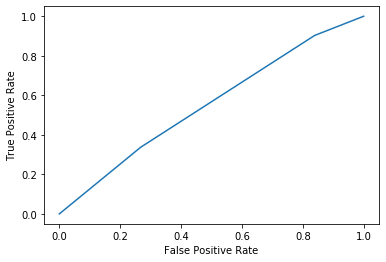

In [17]:
k=np.linspace(0,1,10)
TPR=[]
FPR=[]
for n in k:
    outputs=[]
    targets=[]
    for data,target in test_loader:
        output=model(data.float())
        output=torch.sigmoid(output.cpu())
        output=list(np.where(output<n,0,1)[:])
        target=list(target.cpu().numpy())
        outputs+=output
        targets+=target

    outputs_of_model=np.stack(outputs,axis=0).squeeze().astype(dtype=int)
    targets_of_model=np.array(targets).astype(dtype=int)
    
    #detect True Negatives, False Positives, False Negatives, True Positives
    TN=np.array(targets_of_model[outputs_of_model==0]==0).sum()
    FP=np.array(targets_of_model[outputs_of_model==1]==0).sum()
    FN=np.array(targets_of_model[outputs_of_model==0]==1).sum()
    TP=np.array(targets_of_model[outputs_of_model==1]==1).sum()

    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))
    
#Plot True Positive Rate and False Positive Rate
plt.plot(FPR,TPR)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

AUC=0.0;
for i in range(len(TPR)-1):
    AUC+=np.abs((TPR[i]+TPR[i+1])*(FPR[i+1]-FPR[i])/2)
  
  
print("Estimated AUC: {}".format(AUC))

In [18]:
outputs=[]
targets=[]
for data,target in test_loader:
    output=model(data.float())
    output=torch.sigmoid(output.cpu())
    output=list(np.where(output<0.5,0,1)[:])
    target=list(target.cpu().numpy())
    outputs+=output
    targets+=target

outputs_of_model=np.stack(outputs,axis=0).squeeze().astype(dtype=int)
targets_of_model=np.array(targets).astype(dtype=int)


TN=np.array(targets_of_model[outputs_of_model==0]==0).sum()
FP=np.array(targets_of_model[outputs_of_model==1]==0).sum()
FN=np.array(targets_of_model[outputs_of_model==0]==1).sum()
TP=np.array(targets_of_model[outputs_of_model==1]==1).sum()


print("True Positives: {}".format(TP))
print("True Negatives: {}".format(TN))
print("False Positives: {}".format(FP))
print("False Negatives: {}".format(FN))


precision=TP/(TP+FP)
recall=TP/(TP+FN)
print("Model Precision: {}".format(precision))
print("Model Recall: {}".format(recall))

F1=2*precision*recall/(precision+recall)

print("F1-score: {}".format(F1))

True Positives: 569
True Negatives: 544
False Positives: 431
False Negatives: 450
Model Precision: 0.569
Model Recall: 0.5583905789990187
F1-score: 0.5636453689945518


In [19]:
(TP+TN)/(TP+FP+TN+FN)

0.5581745235707122